# Home Assignment No. 1

To solve this task, you will write a lot of code to try several machine learning methods for classification and regression.
* You are **HIGHLY RECOMMENDED** to read relevant documentation, e.g. for [python](https://docs.python.org/3/), [numpy](https://docs.scipy.org/doc/numpy/reference/), [matlpotlib](https://matplotlib.org/) and [sklearn](https://scikit-learn.org/stable/). Also remember that seminars, lecture slides, [Google](http://google.com) and [StackOverflow](https://stackoverflow.com/) are your close friends during this course (and, probably, whole life?).

* If you want an easy life, you have to use **BUILT-IN METHODS** of `sklearn` library instead of writing tons of your own code. There exists a class/method for almost everything you can imagine (related to this homework).

* You have to write **CODE** directly inside specified places marked by comments: **BEGIN/END Solution**. Do not create new cells.

* In some problems you are asked to provide a short discussion of the results. For that find the specific place marked via **Your text answer: \<write your answer\>**.

* For every separate problem or subproblem (if specified) you can get only 0 points or maximal points for this problem. There are **NO INTERMEDIATE scores**. So make sure that you did everything required in the task.

* Your **SOLUTION** notebook **MUST BE REPRODUCIBLE**, i.e., if the reviewer decides to restart the notebook and run all cells, after all the computation he will obtain exactly the same solution (with all the corresponding plots) as in your uploaded notebook. For this purpose, we suggest fixing random `seed` or (better) define `random_state=` inside every algorithm that uses some pseudorandomness.

* Your code must be clear to the reviewer. For this purpose, try to include necessary comments inside the code. But remember: **GOOD CODE MUST BE SELF-EXPLANATORY** without any additional comments.

* Many `sklearn` algorithms support multithreading (Ensemble Methods, Cross-Validation, etc.). Check if the particular algorithm has `n_jobs` parameters and set it to `-1` to use all the cores.

* **Cheating even in one task leads to 0 grade for the whole homework**






To begin with, let's import the essential (for this assignment) libraries.

In [1]:
# Your imports
import numpy as np
import sklearn
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_moons, make_circles
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC



In [2]:
# Your imports

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, QuantileTransformer, FunctionTransformer, MinMaxScaler
from sklearn.random_projection import GaussianRandomProjection
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import GridSearchCV, PredefinedSplit

import matplotlib.gridspec as gridspec
from mlxtend.plotting import plot_decision_regions
from mlxtend.plotting import plot_decision_regions

import time
import warnings
warnings.filterwarnings('ignore')

## Task 1. Regression with Polynomial and Radial Basis Functions (1+1 points)

This assignment explores how **ordinary least squares regression**, which typically assumes a linear hypothesis class, can be extended to non-linear regression functions using **polynomial basis functions** and **radial basis functions**.

The target function we aim to approximate is:

$$
y_{\text{true}} = f_{\text{true}}(x) = 6 (\sin(x + 2) + \sin(2x + 4))
$$

Since this function depends on a single variable, it is classified as a **univariate function**.

To generate **synthetic data**, we sample $n = 750$ points from a **uniform distribution** within the interval **$[-7.5, 7.5]$**.


In [3]:
# The true function
def f_true(x):
  y = 6.0 * (np.sin(x + 2) + np.sin(2 * x + 4))
  return y

np.random.seed(777)                       # We fix seed for the greater reproducibility

n = 750                                  # Number of data points
X = np.random.uniform(-7.5, 7.5, n)
e = np.random.normal(0.0, 5.0, n)        # Random Gaussian noise
y = f_true(X) + e

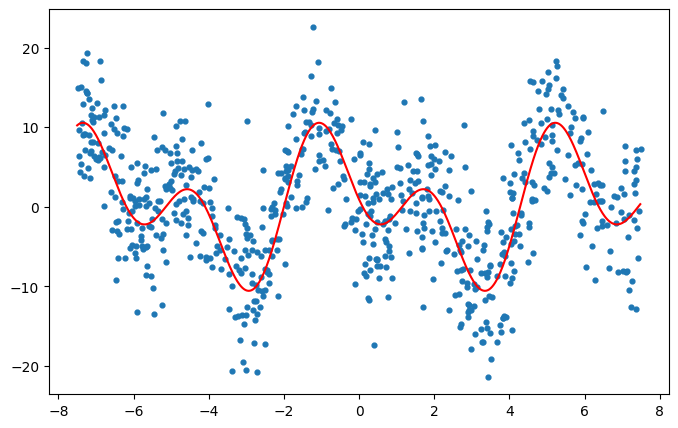

In [4]:
%matplotlib inline
plt.figure(figsize=(8,5))

# Plot the data
plt.scatter(X, y, 12, marker='o')     #With gaussian noise

# Plot the true function, which is really "unknown"
x_true = np.arange(-7.5, 7.5, 0.02)
y_true = f_true(x_true)
plt.plot(x_true, y_true, marker='None', color='r') # Just the sin wave signal

To ensure that a model generalizes well on unseen data, we must carefully balance fit and complexity (i.e., the trade-off between bias and variance). To achieve this, the dataset $\mathcal{D}$ is randomly divided into three distinct subsets:

- **Training set**: $\mathcal{D}_{\text{trn}}$ contains the actual training samples used to **train the model**;
- **Validation set**: $\mathcal{D}_{\text{val}}$ consists of validation examples used to **optimize model hyperparameters** (e.g., selecting $\lambda > 0$ in ridge regression) and determine the best balance between fit and complexity;
- **Test set**: $\mathcal{D}_{\text{tst}}$ includes test examples that help **assess the model’s performance on new, unseen data**.


In this example, we randomly divide the dataset into three mutually exclusive subsets:

- **Training set**: $\mathcal{D}_{\text{trn}}$ comprises **60%** of $\mathcal{D}$.
- **Validation set**: $\mathcal{D}_{\text{val}}$ comprises **10%** of $\mathcal{D}$.
- **Test set**: $\mathcal{D}_{\text{tst}}$ comprises **30%** of $\mathcal{D}$.


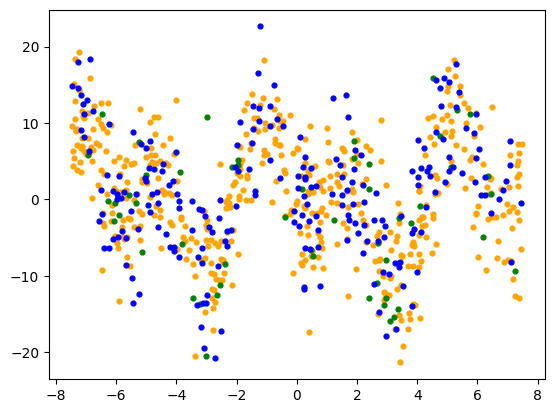

In [5]:
tst_frac = 0.3  # Fraction of examples to sample for the test set
val_frac = 0.1  # Fraction of examples to sample for the validation set

X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=tst_frac, random_state=42)

X_trn, X_val, y_trn, y_val = train_test_split(X_trn, y_trn, test_size=val_frac, random_state=42)


plt.figure()
plt.scatter(X_trn, y_trn, 12, marker='o', color='orange')
plt.scatter(X_val, y_val, 12, marker='o', color='green')
plt.scatter(X_tst, y_tst, 12, marker='o', color='blue')

This problem is an extension of **ordinary least squares regression**, which typically considers a hypothesis class of **linear regression functions**, and instead applies it to **non-linear regression functions** by using **polynomial basis functions**. To adapt linear regression for nonlinear models, we must transform the data into a higher-dimensional space. The nonlinear hypothesis class we will use consists of polynomials of degree $ d $, represented as:

$$
f(x) = w_0 + w_1x + w_2x^2 + \dots + w_dx^d
$$

or as a **linear combination of polynomial basis functions**:

$$
f(x) = [w_0, w_1, w_2, \dots, w_d]^T
\begin{bmatrix}
1 \\
x \\
x^2 \\
\vdots \\
x^d
\end{bmatrix}.
$$

The set of monomials $$ \{1, x, x^2, \dots, x^d\} $$ are referred to as basis functions, where each basis function $ x^k $ is associated with a weight $ w_k $ for $ k = 1, \dots, d $. We transform each univariate data point $x_i$ into a $d$ -dimensional feature vector:

$$
\phi(x_i) \to [1, x_i, x_i^2, \dots, x_i^d].
$$

Applying this transformation to every data point results in the formation of a Vandermonde matrix:

$$
\Phi =
\begin{bmatrix}
1 & x_1 & x_1^2 & \dots & x_1^d \\
1 & x_2 & x_2^2 & \dots & x_2^d \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & x_n & x_n^2 & \dots & x_n^d
\end{bmatrix}.
$$


### Subproblem 1.1. Regression with


Implement the functions below to perform polynomial transformation, train a linear regression model using ordinary least squares, and evaluate the model using mean squared error (MSE).

#### a. Polynomial transformation
Write the function  which converts univariate data into a Vandermonde matrix using polynomial basis functions. This transformation allows us to model polynomial relationships in a higher-dimensional space.

  
Each input $x_i$ is transformed into:

$$
\phi(x_i) = [1, x_i, x_i^2, \dots, x_i^d]
$$

where $d $ is the polynomial degree.

---

#### b. Training a Linear Regression model
Write the function, which learns the optimal weights $w$ using ordinary least squares regression.


The closed-form solution for the weight vector is:
$
w = (\Phi^T \Phi)^{-1} \Phi^T y
$

where:  
- $\Phi$ is the Vandermonde matrix (polynomial transformed data).  
- $y$ is the target labels.  
- $w$ represents the optimal model weights.  

---

#### c. Model evaluation (MSE)
Write the function which computes the MSE between the actual values $ y $ and the predicted values $\hat{y}$.
  
The mean squared error is computed as:

$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \Phi w)^2
$

where:  
- $ n $ is the number of samples.  
- $ \Phi w $ gives the model’s predictions.



---


In [6]:
### BEGIN Solution (do not delete this comment)

def polynomial_transform(x, d):
    return np.vander(x, N=d, increasing=True)

def train_linreg(Phi, y):
    w = np.linalg.inv(Phi.T @ Phi) @ Phi.T @ y
    return w
def predict(Phi, w):
    return Phi @ w
def mse_custom(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)
### END Solution (do not delete this comment)



#### 4. Provide plot Polynomial degree $d$ vs. Validation error and discuss  

We can explore the effect of complexity by varying $d$ to steadily increase the **non-linearity** of the models.  
For each model, we train using the transformed training data $\Phi_{\text{train}}$, whose dimension increases with $d$.  
Then, we evaluate its performance on the transformed validation data and estimate how well the model will generalize by checking its performance on the test data.


From the plot of **$d$ vs. validation error** below, which choice of $d$ do you expect will **generalize best**?  




NameError: name 'valationErr' is not defined

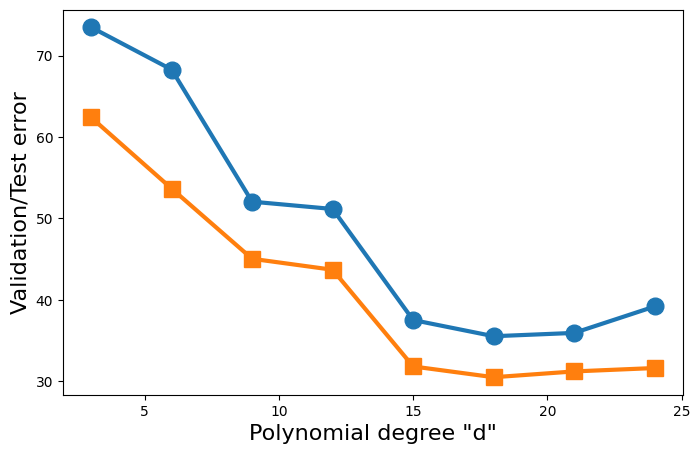

In [7]:
w = {}               # Dictionary to store all the trained models
validationErr = {}
testErr = {}

for d in range(3, 25, 3):  # Iterate over polynomial degree from 3 to 25 in steps of 3

    ### BEGIN Solution (do not delete this comment)

    # Transform training data into d dimensions
    Phi_trn = polynomial_transform(X_trn, d)
    

    # Transform validation data into d dimensions
    Phi_val = polynomial_transform(X_val, d)
    

    # Transform test data into d dimensions
    Phi_test = polynomial_transform(X_tst, d)
    

    w[d] = train_linreg(Phi_trn, y_trn)

    y_val_pred = predict(Phi_val, w[d])
    validationErr[d] = mse_custom(y_val, y_val_pred)

    y_tst_pred = predict(Phi_test, w[d])
    testErr[d] = mse_custom(y_tst, y_tst_pred)
    ### END Solution (do not delete this comment)


plt.figure(figsize=(8,5))
plt.plot(validationErr.keys(), validationErr.values(), marker='o', linewidth=3, markersize=12)
plt.plot(testErr.keys(), testErr.values(), marker='s', linewidth=3, markersize=12)
plt.xlabel('Polynomial degree "d"', fontsize=16)
plt.ylabel('Validation/Test error', fontsize=16)
plt.xticks(list(valationErr.keys()), fontsize=12)
plt.legend(['valation Error', 'Test Error'], fontsize=16)
plt.axis([2, 27, 10, 400])

(np.float64(-8.0), np.float64(8.0), np.float64(-40.0), np.float64(40.0))

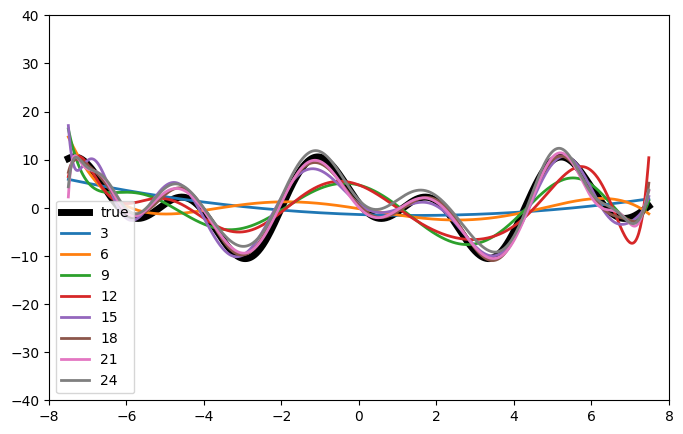

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(x_true, y_true, marker='None', linewidth=5, color='k')
for d in range(3, 25, 3):
    ### BEGIN Solution (do not delete this comment)
    Phi_test = polynomial_transform(x_true, d)
    y_pred = predict(Phi_test, w[d])
    plt.plot(x_true, y_pred, marker='None', linewidth=2)
    ### END Solution (do not delete this comment)

plt.legend(['true'] + list(range(3, 25, 3)))
plt.axis([-8, 8, -40, 40])

**Your text answer (do not delete this comment)**:  
I expect that the best value for d will be in the middle of provided range(e.g. $d=15$), since for small values of d there are not enough features to predict non-linear function, and for big values overfitting obviously will occured. 


### Subproblem 1.2. Regression with Radial Basis Functions (1 points)

Previously, we explored how to extend linear regression to nonlinear cases using polynomial basis functions, where features were introduced as $\phi(x) = x^k$.  
Now, we consider an alternative approach using Gaussian radial basis functions, which take the form:

$$
\phi(x) = e^{-\gamma (x - \mu)^2}
$$

where $\mu$ represents the center of the function and $\gamma > 0$ controls its width/spread.  

##### Comparison with Polynomial Basis Functions  
- In polynomial basis regression, the model's complexity was determined by the polynomial degree $d$.
- In radial basis regression, we must decide:
  - How many radial basis functions to include.
  - Where their centers and widths should be.

For simplicity, we assume $\gamma = 0.1$ is fixed.  
Rather than selecting a predefined number of radial basis functions and their centers, we take a different approach:  

**Each data point is treated as the center of a radial basis function.**  

This results in the following model representation:

$$
f(x) = [w_1, w_2, w_3, \dots, w_n]^T
\begin{bmatrix}
e^{-\gamma (x - x_1)^2} \\
e^{-\gamma (x - x_2)^2} \\
e^{-\gamma (x - x_3)^2} \\
\vdots \\
e^{-\gamma (x - x_n)^2}
\end{bmatrix}.
$$

---

#### **Radial Basis Function Transformation**
This transformation constructs **radial basis functions** centered at each data point.  
Each function has a weight $w_i$, where $i = 1, \dots, n$.  
We transform each univariate data point $x_j$ into an $n$-dimensional vector:

$$
\phi(x_j) \to [ \dots, e^{-\gamma (x_j - x_i)^2}, \dots ].
$$

Applying this transformation to all data points results in the radial-basis kernel matrix:

$$
\Phi =
\begin{bmatrix}
1 & e^{-\gamma (x_1 - x_2)^2} & e^{-\gamma (x_1 - x_3)^2} & \dots & e^{-\gamma (x_1 - x_n)^2} \\
e^{-\gamma (x_2 - x_1)^2} & 1 & e^{-\gamma (x_2 - x_3)^2} & \dots & e^{-\gamma (x_2 - x_n)^2} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
e^{-\gamma (x_n - x_1)^2} & e^{-\gamma (x_n - x_2)^2} & e^{-\gamma (x_n - x_3)^2} & \dots & 1
\end{bmatrix}.
$$




#### **a.  Compute the Radial-Basis Kernel Matrix**  
Implement a function that takes univariate data as input and constructs the **radial-basis kernel matrix**.  
This transformation maps one-dimensional data into an $n$-dimensional feature space, using Gaussian radial-basis functions centered at each data point.  
This approach enables nonlinear regression, making it possible to model more complex relationships.

---

#### **b. Ridge regression training**  
Develop a function that learns weights using ridge regression, given:
- A radial-basis kernel matrix $\Phi$
- The target labels $y$
- A regularization parameter $\lambda > 0$

The weight computation follows the formula:

$$
\mathbf{w} = (\Phi^T \Phi + \lambda I_n)^{-1} \Phi^T y
$$

This method helps prevent overfitting by adding a regularization term to the regression.

---

#### **c.  Model complexity vs. generalization**  
We analyze the tradeoff between fit and complexity by varying the regularization parameter $\lambda$:

$$
\lambda \in [10^{-3}, 10^{-2}, \dots, 1, \dots, 10^3]
$$

For each model:
1. Train using the transformed training data $\Phi_{\text{train}}$.
2. Evaluate its performance on the **valation** and **test datasets**.
3. Plot two curves:
   - **$\lambda$ vs. valation error**
   - **$\lambda$ vs. test error**

The goal is to determine the optimal $\lambda$ values that balance bias and variance while ensuring good generalization.


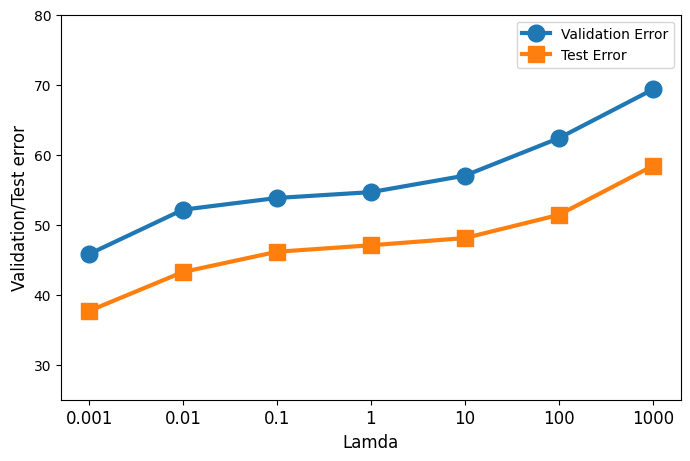

In [ ]:
### BEGIN Solution (do not delete this comment)
def radial_basis_kernel_matrix(X, X_train, gamma=0.1):
    Phi = np.exp(-gamma * (X[:, None] - X_train[None, :])**2)
    return Phi

def train_ridge(Phi, y, lamda):
    w = np.linalg.inv(Phi.T @ Phi + lamda * np.eye(Phi.shape[1])) @ Phi.T @ y
    return w
### END Solution (do not delete this comment)


w1 = {}               # Dictionary to store all the trained models
validationErr1 = {}   # Validation error of the models
testErr1 = {}         # Test error of all the models
lamda = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
xi = np.arange(len(lamda))

### BEGIN Solution (do not delete this comment)
# Iterate over lamda values from the list
for l in lamda:
    # Transform training data into d dimensions
    Phi_trn = radial_basis_kernel_matrix(X_trn, X_trn)
    

    # Transform validation data into d dimensions
    Phi_val = radial_basis_kernel_matrix(X_val, X_trn)
    

    # Transform test data into d dimensions
    Phi_test = radial_basis_kernel_matrix(X_tst, X_trn)
    

    w1[l] = train_ridge(Phi_trn, y_trn, l)
    y_val_pred = predict(Phi_val, w1[l])
    validationErr1[l] = mse_custom(y_val, y_val_pred)

    y_tst_pred = predict(Phi_test, w1[l])
    testErr1[l] = mse_custom(y_tst, y_tst_pred)
    ### END Solution (do not delete this comment)

### END Solution (do not delete this comment)



# Plot all the models
plt.figure(figsize=(8,5))
plt.ylim(25,80)

plt.plot(xi, validationErr1.values(), marker='o', linewidth=3, markersize=12)
plt.plot(xi, testErr1.values(), marker='s', linewidth=3, markersize=12)

plt.xlabel('Lamda', fontsize=12)
plt.ylabel('Validation/Test error', fontsize=12)

plt.xticks(xi, ('0.001', '0.01', '0.1', '1', '10','100','1000'),fontsize=12)
plt.legend(['Validation Error', 'Test Error'], fontsize=10)


#### **d. Discussion**  


Plot the learned models alongside the true model, similar to the polynomial basis function case.  

Key discussion points:
- **How does the linearity of the model change with $\lambda$?**
- **What trends emerge as $\lambda$ increases?**


The objective is to analyze how regularization affects the flexibility of the model and its ability to generalize effectively.


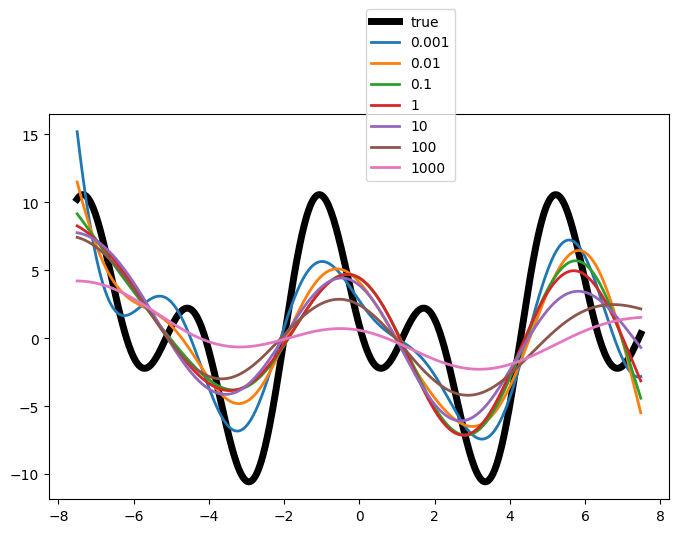

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(x_true, y_true, marker='None', linewidth=5, color='k')
lamda=[0.001, 0.01, 0.1, 1, 10, 100, 1000]


for l_index, l in enumerate(lamda):
### BEGIN Solution (do not delete this comment)
    Phi_test = radial_basis_kernel_matrix(x_true, X_trn)
    y_pred = predict(Phi_test, w1[l])
    plt.plot(x_true, y_pred, marker='None', linewidth=2)

### END Solution (do not delete this comment)



plt.legend(['true'] + lamda,loc='center left', bbox_to_anchor=(0.5, 1.05))

**Your text answer (do not delete this comment)**:

1. **Small $\lambda$ (0.001–0.1)**:  
   - Model is highly nonlinear, closely fitting the data.  
   - High flexibility, capturing fine details.  

2. **Moderate $\lambda$ (1–10)**:  
   - Smoother function, reducing extreme variations.  
   - Strikes a balance between nonlinearity and generalization.  

3. **Large $\lambda$ (100–1000)**:  
   - Model becomes increasingly linear.  
   - Regularization dominates, suppressing nonlinearity.  

**Trends as $\lambda$ Increases**  
- **From nonlinear to linear**: Small $\lambda$ allows complex shapes; large $\lambda$ enforces linearity.  
- **Loss of flexibility**: Higher $\lambda$ flattens curves, restricting adaptability.  


## Task 2. Decision Rules and Feature Engineering (1 point)

In this task, your goal is to visualize the decision rules of several classifiers applied to an artificial $2$-dimensional dataset inspired by the dataset that can be created using the built-in `sklearn.datasets` method called `make_moons`. The main difference is a sun added outside the moons. In the cell below we generate the dataset.

In [ ]:
def make_sunny_moons(n_sun=150, n_moons=300, noise_moons=0.35, noise_sun=0.25, sun_radius=1.9, theta=np.pi/3.7):
    X_moons, y_moons = make_moons(n_samples=n_moons, noise=noise_moons, random_state=0xC0FFEE)
    X_moons[:, 1] += 0.5 * X_moons[:, 0]

    np.random.seed(0xC0FFEE)
    angles = np.linspace(0, 2 * np.pi, n_sun)
    radii = sun_radius + np.random.normal(scale=0.3, size=n_sun)
    X_sun = radii[:, None] * np.column_stack([np.cos(angles), np.sin(angles)]) + np.array([0.7, 0.4])
    X_sun += np.random.normal(scale=noise_sun, size=X_sun.shape)
    y_sun = 2 * np.ones(n_sun)

    X = np.vstack([X_moons, X_sun])
    y = np.concatenate([y_moons, y_sun]).astype(int)

    X -= X.mean(axis=0)

    c, s = np.cos(theta), np.sin(theta)
    R = np.array([[c, -s], [s, c]])
    X[:, :2] = X[:, :2] @ R

    return X, y

X, y = make_sunny_moons(n_sun=150, n_moons=300, noise_moons=0.35, noise_sun=0.25)

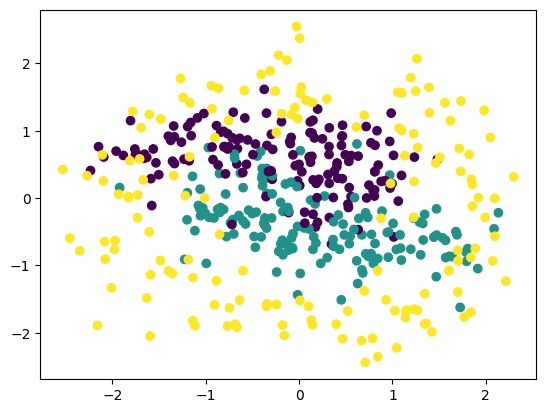

In [ ]:
plt.scatter(X[:,0], X[:,1], c=y)
plt.show()

### Subproblem 2.1. Decision Rule Plotting (1 point)

The goal of the subproblem is to fit the following classifiers on features `X` to target `y`:
* Decision Tree (single!) with small depth ($\leq 6$);
* Random Forest with a small number of trees ($\leq 20$) of small depth ($\leq 6$);
* Logistic Regression;
* Support Vector Machine with RBF kernel;
* Gaussian Naive Bayes;
* k-Nearest Neighbor Classifier with a small number of neighbors ($3-5$);

For all the fitted classifiers you have to plot the decision regions (the example is shown below the cell). Each plot must have **Title** which contains the name of the classifier and its accuracy (only **two** decimal places) on the data.

You can read about Support Vector Machine (SVM) here: https://scikit-learn.org/stable/modules/svm.html

You can write the plotting code on your own, but we highly recommend just to use `mlxtend` library (`pip install mlxtend` in linux terminal), which has an awesome one-line decision rule plotting function ([google](http://google.com) it).

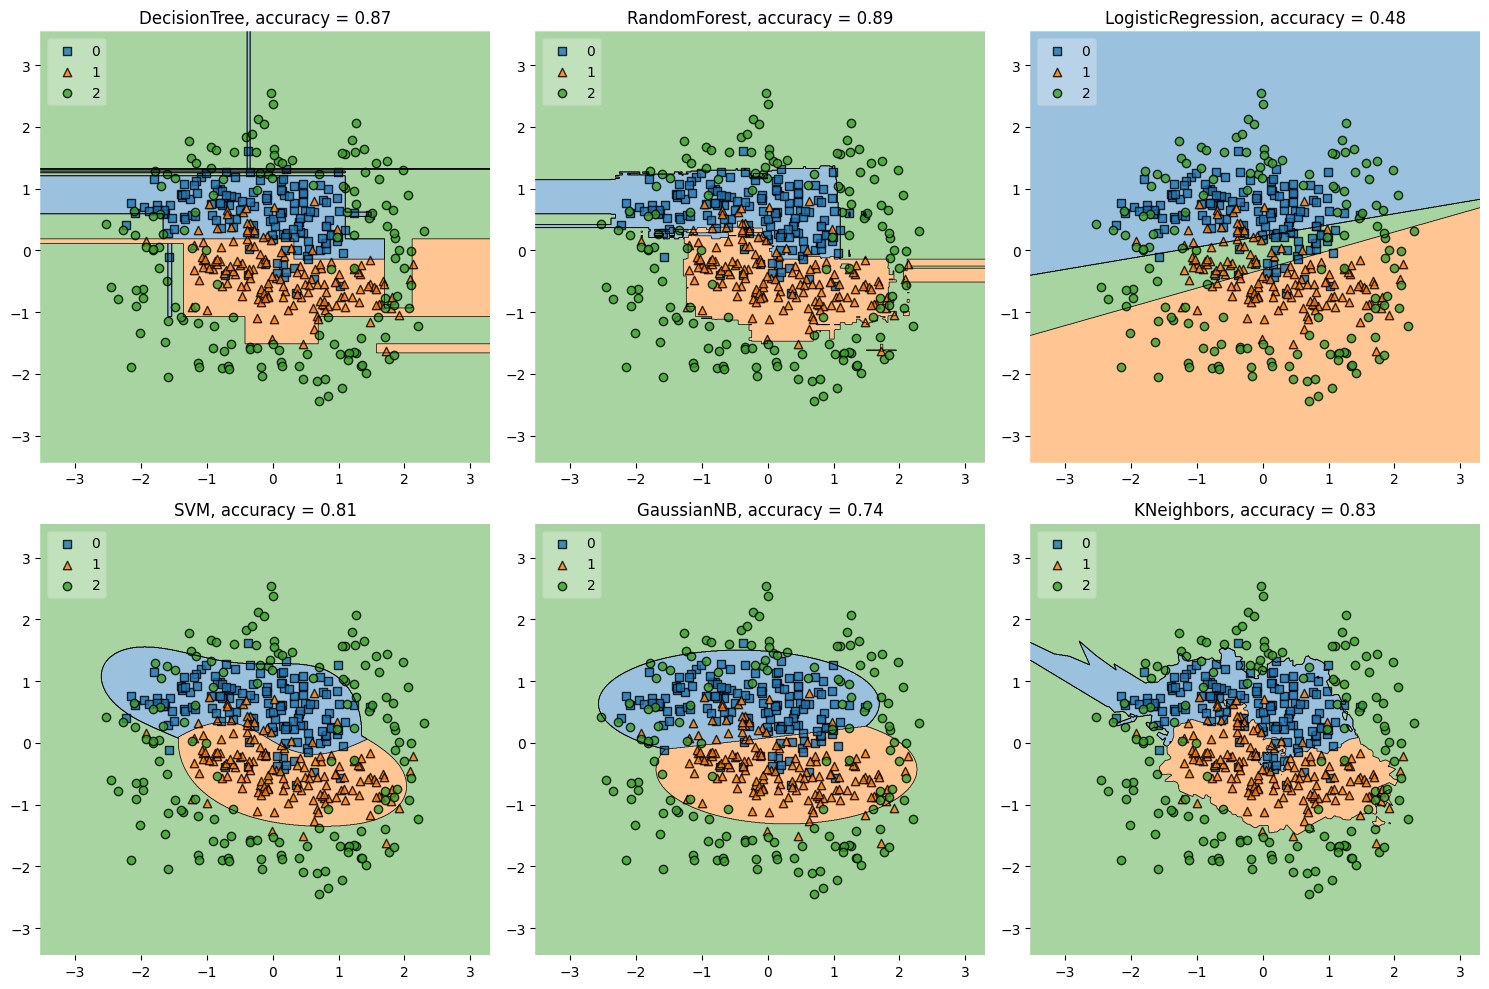

In [ ]:
### BEGIN Solution (do not delete this comment)


classifiers = [
    ("DecisionTree", 
     DecisionTreeClassifier(max_depth=6, random_state=42)),
    ("RandomForest", 
     RandomForestClassifier(n_estimators=20, max_depth=6, random_state=42)),
    ("LogisticRegression", 
     LogisticRegression()),
    ("SVM", 
     SVC(kernel="rbf", random_state=42)),
    ("GaussianNB", 
     GaussianNB()),
    ("KNeighbors", 
     KNeighborsClassifier(n_neighbors=5))
]

# Create a grid of subplots: 2 rows, 3 columns
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Loop over each classifier and its corresponding subplot
for ax, (name, clf) in zip(axes.flatten(), classifiers):
    # Fit the classifier
    clf.fit(X, y)
    # Calculate accuracy on the whole dataset (X, y)
    accuracy = clf.score(X, y)
    
    # Plot decision regions
    plot_decision_regions(X, y, clf=clf, legend=2, ax=ax)
    
    # Set the title with accuracy up to two decimals
    ax.set_title(f"{name}, accuracy = {accuracy:.2f}", fontsize=12)

plt.tight_layout()
plt.show()


### END Solution (do not delete this comment)

### Subproblem 2.2. Pipeline: Fitting to Data by Feature Engineering (1 point)
In previous task 2.1 we saw that several classifiers obviously failed fitting to data. This happened because the decision rule of the classifier has a restricted form (e.g. linear for linear models), while the data is more complicated.

One may try to change the parameters of the classifier (e.g. increase the number of trees in Forest) in order to improve accuracy, but some models (especially linear) do not have parameters that can change the form of the decision rule.

In this case the **feature engineering** helps: one may try to compute new (e.g. non-linear) features based on the existing pool and fit the classifier in the new features. This may help low-complex classifiers to fit to hard data dependencies.

Your task it to
* Choose **one classifier** from the previous problem among Decision Tree, Support Vectore Machine, Random Forest, Naive Bayes, Logistic Regression, KNN;
* By generating of additional features (e.g. polynomial) make them achieve accuracy $>=0.90$. (**Remember about restrictions of hyperparameters from 2.1**)
* Plot his decision rule in the original feature space.

It is your choice how to generate features. You may create hand-crafted features and add them manually. Nevertheless, we **highly suggest** to get used to and apply the following builtin `sklearn` methods:
* `PolynomialFeatures`, `GaussianRandomProjection` among others - for feature generation
* `StandartScaler`, `MinMaxScaler` among others - for feature scaling
* `Pipeline` - for combining several operations in a row (e.g. feature creation & prediction)

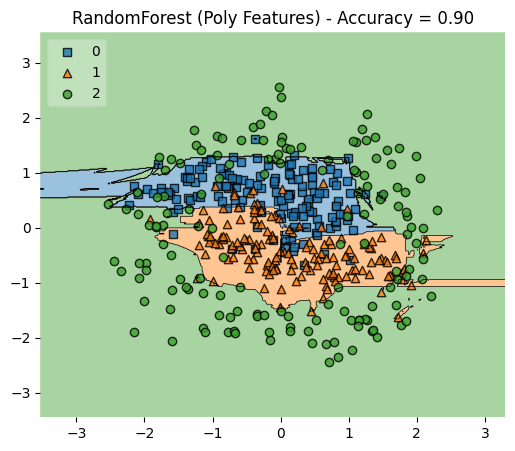

In [ ]:
### BEGIN Solution (do not delete this comment)

poly_logreg_pipeline = Pipeline([
    ("poly", PolynomialFeatures(degree=9, include_bias=False)),  
    ("scaler", StandardScaler()),
    ("rfc", RandomForestClassifier(n_estimators=20, max_depth=6, random_state=42))
])


poly_logreg_pipeline.fit(X, y)
accuracy = poly_logreg_pipeline.score(X, y)

plt.figure(figsize=(6, 5))
plot_decision_regions(X, y, clf=poly_logreg_pipeline, legend=2)
plt.title(f"RandomForest (Poly Features) - Accuracy = {accuracy:.2f}")
plt.show()

### END Solution (do not delete this comment)


## Task 3. Ensembling Methods (1+1 points)
In this problem, you are to deal with [Concrete Compressive Strength Dataset](https://www.kaggle.com/elikplim/concrete-compressive-strength-data-set). Your goal will be to determine the optimal parameters for three Ensemble based **Regressors** and compare the quality metrics. Let's load the data and split it into test and train parts.

In [ ]:
data = pd.read_csv('data/concrete.csv').astype(float)
X = data.drop('concrete_compressive_strength', axis=1)
y = data.concrete_compressive_strength
n = len(X)

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=int(n*0.15), random_state=0xC0FFEE)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=int(n*0.15), random_state=0xC0FFEE)

data.sample(3).sort_index()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,concrete_compressive_strength
70,374.0,189.2,0.0,170.1,10.1,926.1,756.7,3.0,34.40
550,393.0,0.0,0.0,192.0,0.0,940.6,785.6,7.0,27.74
888,153.0,145.0,0.0,178.0,8.0,1000.0,822.0,28.0,19.01


In this problem, we split the whole data into the **train part** (on which we train), **validation part** (on which we tune hyperparameters) and **test part** (where we compute the final test score on the validated model).

In this problem, you are to consider the `RandomForestRegressor`, `ExtraTreesRegressor` and `XGBRegressor` for the prediction of concrete compressive strength under **squared loss function** (mean squared error).

1. Recall that Random Forest was discussed in the lectures.
2. [Extremely Randomized Forest](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.65.7485&rep=rep1&type=pdf) is another bootstrapped forest with a simple tree building algorithm. Basically, each split of each tree node is chosen at random both w.r.t. feature and threshold (while in the random forest the split minimizes impurity).
3. Gradient Boosting Machines (GBM) is a historical and logical continuation of the first boosting algorithms. In a way, one can consider AdaBoost as another variant of GBMs. These methods are extremely powerful tools, widely used in industry, research and various machine learning competitions. In this task we offer to focus on one variant of GBM called [XGBoost](https://github.com/dmlc/xgboost/tree/master/python-package).

Make sure that you have installed the XGBoost package before starting the task.

### Subproblem 3.1. Hyperparameters tuning (1 point)

* For both Forests and GBM perform the Grid Search (on the validation data) over most important algorithm's parameters (what are they?) to determine the optimal hyperparameters.
* For the optimal hyperparameters output the train score, the validation score and the test score (use the model with best hyperparameters refitted on the train set).

In [ ]:
### BEGIN Solution (do not delete this comment)
from xgboost import XGBRegressor
from sklearn.model_selection import ParameterGrid

def grid_search_on_valid(model_class, param_grid, X_train, y_train, X_val, y_val, extra_params=None):
    if extra_params is None:
        extra_params = {}
    best_valid_mse = float('inf')
    best_params = None
    for params in ParameterGrid(param_grid):
        model = model_class(**{**params, **extra_params})
        model.fit(X_train, y_train)
        current_mse = mse(y_val, model.predict(X_val))
        if current_mse < best_valid_mse:
            best_valid_mse = current_mse
            best_params = params
    return best_params, best_valid_mse

def get_mse_scores(model_class, best_params, X_train, y_train, X_val, y_val, X_test, y_test, extra_params=None):
    if extra_params is None:
        extra_params = {}
    model = model_class(**{**best_params, **extra_params})
    model.fit(X_train, y_train)
    train_mse = mse(y_train, model.predict(X_train))
    valid_mse = mse(y_val, model.predict(X_val))
    test_mse = mse(y_test, model.predict(X_test))
    return train_mse, valid_mse, test_mse

results = {}
best_params_all = {}

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}
best_params_rf, _ = grid_search_on_valid(RandomForestRegressor, param_grid_rf, X_train, y_train, X_val, y_val, extra_params={'random_state': 0})
mse_rf = get_mse_scores(RandomForestRegressor, best_params_rf, X_train, y_train, X_val, y_val, X_test, y_test, extra_params={'random_state': 0})
results['RandomForestRegressor'] = mse_rf
best_params_all['RandomForestRegressor'] = best_params_rf

param_grid_et = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [False, True]
}
best_params_et, _ = grid_search_on_valid(ExtraTreesRegressor, param_grid_et, X_train, y_train, X_val, y_val, extra_params={'random_state': 0})
mse_et = get_mse_scores(ExtraTreesRegressor, best_params_et, X_train, y_train, X_val, y_val, X_test, y_test, extra_params={'random_state': 0})
results['ExtraTreesRegressor'] = mse_et
best_params_all['ExtraTreesRegressor'] = best_params_et

param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
best_params_xgb, _ = grid_search_on_valid(lambda **kwargs: XGBRegressor(objective='reg:squarederror', random_state=0, **kwargs),
                                            param_grid_xgb, X_train, y_train, X_val, y_val)
mse_xgb = get_mse_scores(lambda **kwargs: XGBRegressor(objective='reg:squarederror', random_state=0, **kwargs),
                            best_params_xgb, X_train, y_train, X_val, y_val, X_test, y_test)
results['XGBRegressor'] = mse_xgb
best_params_all['XGBRegressor'] = best_params_xgb

df = pd.DataFrame({
    "Ensemble Classifier": list(results.keys()),
    "Train": [res[0] for res in results.values()],
    "Valid": [res[1] for res in results.values()],
    "Test": [res[2] for res in results.values()]
})
display(df.round(2))
### END Solution (do not delete this comment)

,Ensemble Classifier,Train,Valid,Test
0,RandomForestRegressor,4.91,18.74,23.82
1,ExtraTreesRegressor,1.33,20.34,24.07
2,XGBRegressor,2.80,15.94,16.01


### Subproblem 3.2. Speed Estimation for ensembles (1 point)

The dataset that is going to be used for the problem is  [Telecom Churn Dataset] (https://www.kaggle.com/becksddf/churn-in-telecoms-dataset).

In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import pandas as pd
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

data = pd.read_csv('data/telecom_churn.csv')
cols = ['account length','number vmail messages',
       'total day minutes', 'total day calls', 'total day charge',
       'total eve minutes', 'total eve calls', 'total eve charge',
       'total night minutes', 'total night calls', 'total night charge',
       'total intl minutes', 'total intl calls', 'total intl charge',
       'customer service calls', 'churn']
data = data[cols]
data.iloc[:,-1] = pd.Categorical(data.iloc[:,-1])
data.iloc[:,-1] = data.iloc[:,-1].cat.codes
X, y = data.iloc[:,:-1], data.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,
                                                    random_state=0xC0FFEE)

 You will need to construct a classification model for each method, train it, plot the ROC curve, measure the training time and compare it to each other. Afterward, compare the models' feature importances.

* train the classifier (`RandomForestClassifier`, `ExtraTreesClassifier` and`XGBClassifier`) on the provided dataset
* measure the training time
* measure the average precision score on the test set
* plot ROC-curve

**HINT**: use ```time.perf_counter()``` to measure time.

Training time for extremely randomized forest:  0.10521566699026152
Training time for random forest:  0.20845749997533858
Training time for xgb:  0.1362452079774812
Average precision score for Extra Trees Forest:  0.6853792632435076
Average precision score for Random Forest:  0.7144165134673313
Average precision score for XGBoost:  0.6901130546930151


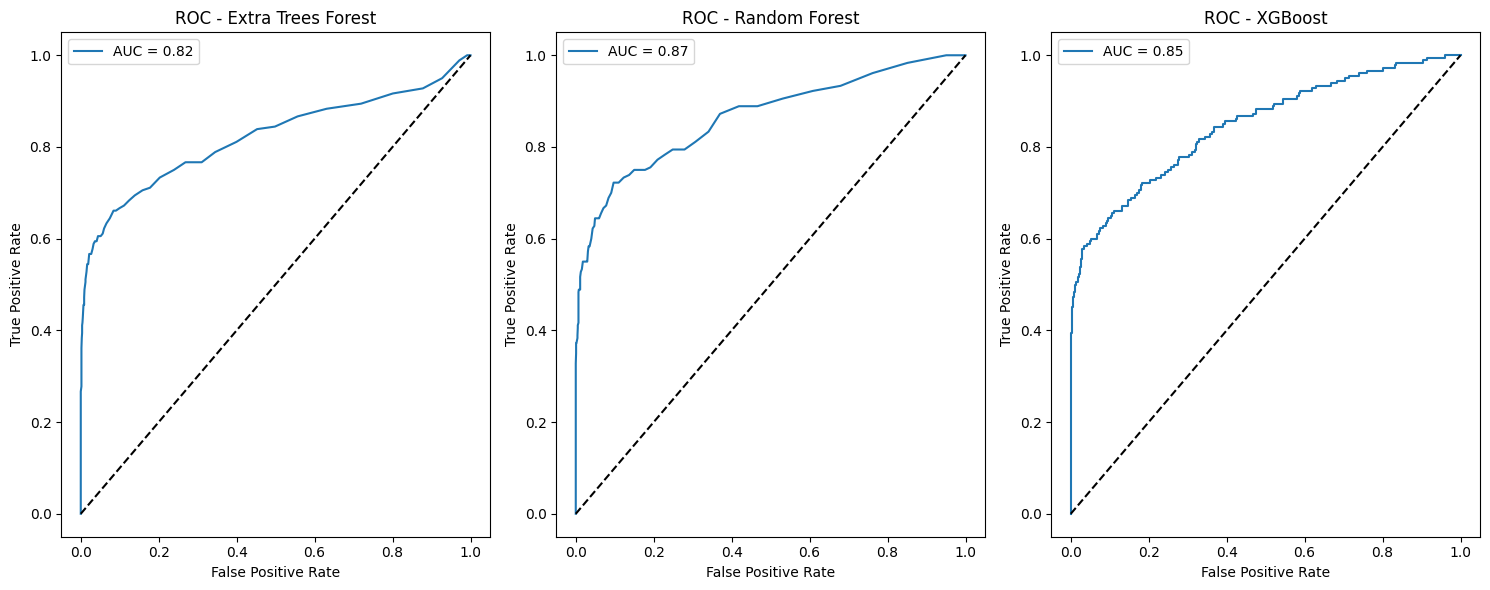

In [ ]:
### BEGIN Solution (do not delete this comment)
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc, average_precision_score

classifiers = {
    "extremely randomized forest": ExtraTreesClassifier(random_state=42),
    "random forest": RandomForestClassifier(random_state=42),
    "xgb": XGBClassifier(eval_metric='logloss', random_state=42)
}
results = {}
for name, clf in classifiers.items():
    start = time.perf_counter()
    clf.fit(X_train, y_train)
    t_time = time.perf_counter() - start
    proba = clf.predict_proba(X_test)[:, 1]
    ap = average_precision_score(y_test, proba)
    fpr, tpr, _ = roc_curve(y_test, proba)
    roc_auc = auc(fpr, tpr)
    results[name] = {"clf": clf, "training_time": t_time, "ap": ap, "fpr": fpr, "tpr": tpr, "roc_auc": roc_auc}

for key in ["extremely randomized forest", "random forest", "xgb"]:
    print("Training time for {}: ".format(key), results[key]["training_time"])
name_mapping = {"extremely randomized forest": "Extra Trees Forest", "random forest": "Random Forest", "xgb": "XGBoost"}
for key in ["extremely randomized forest", "random forest", "xgb"]:
    print("Average precision score for {}: ".format(name_mapping[key]), results[key]["ap"])

names = list(results.keys())
display_names = {"extremely randomized forest": "Extra Trees Forest", "random forest": "Random Forest", "xgb": "XGBoost"}
plt.figure(figsize=(15, 6))
for i, name in enumerate(names):
    plt.subplot(1, 3, i + 1)
    plt.plot(results[name]["fpr"], results[name]["tpr"], label=f"AUC = {results[name]['roc_auc']:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC - {display_names[name]}")
    plt.legend(loc="best")
plt.tight_layout()
plt.show()


### END Solution (do not delete this comment)

* extract and compare the feature importances calculated by the previously trained Extremely Randomized Forest, Random Forest Classifiers and XGBoost. Are they different or the same, why?

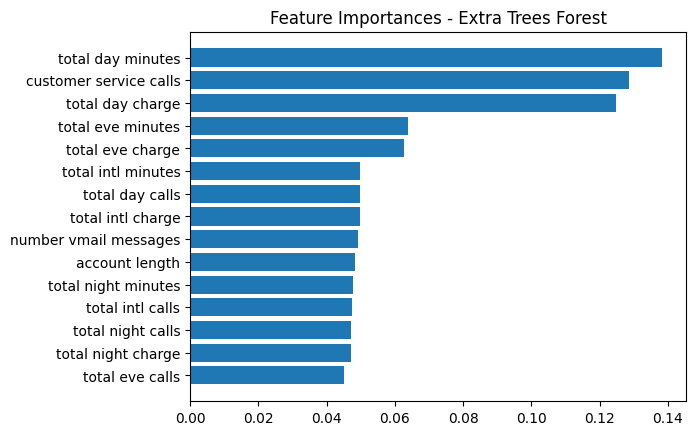

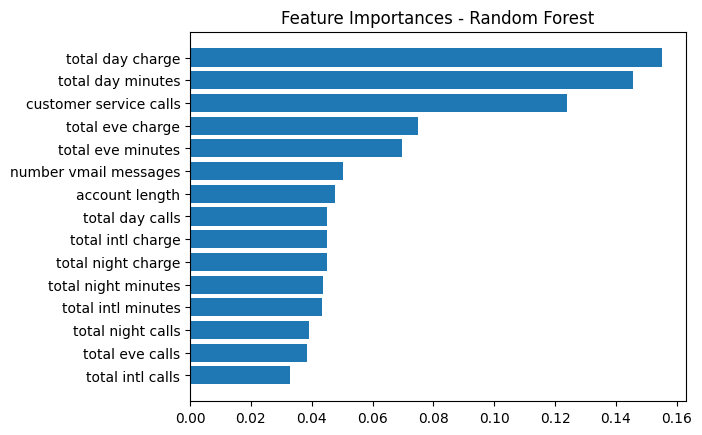

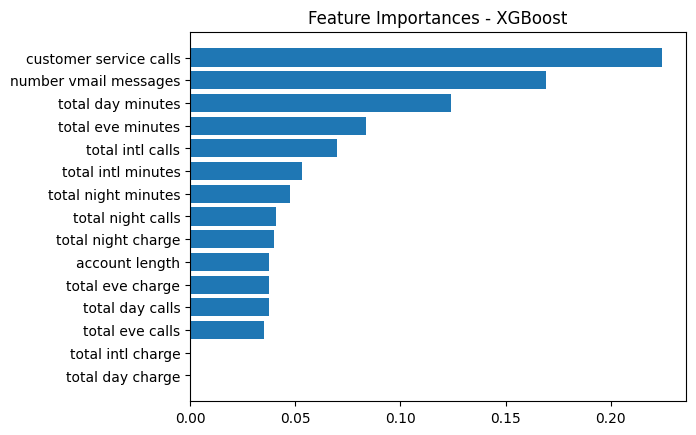

In [ ]:
### BEGIN Solution (do not delete this comment)
#plt.figure(figsize=(15, 6))
for i, name in enumerate(names):
    importances = results[name]["clf"].feature_importances_
    indices = np.argsort(importances)
    plt.barh(range(len(importances)), importances[indices], align='center')
    plt.yticks(range(len(importances)), np.array(X.columns)[indices])
    plt.title(f"Feature Importances - {display_names[name]}")
    plt.show()

### END Solution (do not delete this comment)

**Your text answer (do not delete this comment)**:

From the plot, it's clear that the feature importances from Random Forest and Extra Trees are very similar. This is expected because Random Forest calculates feature importance using the average Gini criterion, while Extra Trees, despite using random splits (which may not be optimal), still computes importance based on the Gini criterion.

In [ ]:
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
%matplotlib inline

In [ ]:
import warnings
warnings.filterwarnings("ignore")

<br>

# Task 4. Stacking (2 points)

Stacking is an ensembling approach, which combines several algorithms (base models) to get better results. This is achieved by **a)** training the base models (any ML models) on the initial train data (or parts of the train data, see the paragraph below), **b)** training the meta-model (also an ML model) on the predictions of those base models.

One of the main problems of stacking is overfitting. To avoid it, when evaluating the performance of the meta-model on the train set, the training data is divided into $ n $ folds, $ (n-1) $ of which are used for training the base models. The $ n $ -th fold is used for the overall prediction (calculating the meta-factor) in the following manner: the predictions on the $ n $ -th fold are made by the base models (already trained on the rest of the dataset), then these predictions are fed as inputs to the meta-model.

When evaluating the performance of the meta-model on the test set, there can be used various approaches$.^{[1]}$ For example, in order, to obtain meta-factors for the test data, the base classifiers can be trained on the entire training set, since the problem of overfitting does not arise here. In other words, if we want to calculate the factors for the test set, we can safely use the training set to train the base classifiers (once again, as it is said in the paragraph above, if we want to calculate factors for the training set, then it is necessary to ensure that the classifier does not predict for those objects on which it has been trained).  

You can read more details about stacking [blockpost](https://blog.statsbot.co/ensemble-learning-d1dcd548e936), [kaggle ensemble guide](https://mlwave.com/kaggle-ensembling-guide/).

P.S. Stacking and Blending are two similar approaches to combining classifiers (ensembling). The difference is that Stacking uses out-of-fold predictions for the train set, and Blending uses a validation set to train the next layer ([source](quora.com/What-are-examples-of-blending-and-stacking-in-Machine-Learning)). Because they are so similar you can use any of them.

[1] http://www.machinelearning.ru/wiki/images/5/56/Guschin2015Stacking.pdf  

**Your task will be:**

* Complete the ```meta_classfier``` function
* Choose 6 different base models (base models can be any models that you know, and can differ between each other by different hyperparameters, models of ml, features e.t.c) and train them.
* Report individual accuracy on test set for each of the models.
* Train the metaclassifier on the original datasets features, report score on test.
* Train the metaclassifier on the base models using $n$-fold cross-validation, as described above. Retrain the base models on the whole training set. Report the test score (accuracy) of the meta-classifier in this case.
* Does stacking help to gain better score?

For this task we will use the dataset fetch_covertype from [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_covtype.html#sklearn.datasets.fetch_covtype). Split it train-test - 65/35.
More detail about this dataset you can find [here](https://archive.ics.uci.edu/ml/datasets/Covertype)

In [10]:
from sklearn import datasets
fc = sklearn.datasets.fetch_covtype()
X_fc = fc.data
y_fc = fc.target

X_train_fc, X_test_fc, y_train_fc, y_test_fc = train_test_split(X_fc, y_fc, test_size=0.35, random_state=42, stratify=y_fc)


Write meta classifier function.

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import StackingClassifier

def meta_classifier(base_clfs, final_classifier, X_train, X_test, y_train, cv):
    """
    Meta classifier prediction using stacking.
    Input:
    :param base_clfs: list,  base classifiers which will be stacked together.
    :param final_classifier: estimator, a classifier which will be used to combine the base estimators.
    :param X_train: numpy array or pandas table, train set.
    :param X_test: numpy array or pandas table, target for train set.
    :param X_train: numpy array or pandas table, test set.
    :param cv: number of cross-validation folds.

    Output:
    :param y_pred: numpy array or pandas table, prediction of meta classifier using stacking on test set.
    :param final_classifier(optional): estimator, trained final_calssifier.


    More details https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html

    """
    ### BEGIN Solution (do not delete this comment)
    
    stacking_clf = StackingClassifier(estimators=base_clfs, 
                                      final_estimator=final_classifier, 
                                      cv=cv, 
                                      passthrough=False)
    stacking_clf.fit(X_train, y_train)

    y_pred = stacking_clf.predict(X_test)
    
    return y_pred, stacking_clf
    
    ### END Solution (do not delete this comment)

### Subproblem 4.1 (1 point)

**4.1.1) Chose 6 different base models (base models can be any models that you know,and can differ with each other by different hyperparameters,  models of ml, features e.t.c) and train them.**

In [12]:
### BEGIN Solution (do not delete this comment)
from sklearn.svm import LinearSVC
classifiers = [
    ("DecisionTree", 
     DecisionTreeClassifier(max_depth=6, random_state=42)),
    ("RandomForest", 
     RandomForestClassifier(n_estimators=20, max_depth=6, random_state=42)),
    ("LogisticRegression", 
     LogisticRegression()),
    ("LinearSVM", 
     LinearSVC(random_state=42)),
    ("GaussianNB", 
     GaussianNB()),
    ("KNeighbors", 
     KNeighborsClassifier(n_neighbors=5))
]

for name, clf in classifiers:
    clf.fit(X_train_fc, y_train_fc)
### END Solution (do not delete this comment)

**4.1.2) Report individual scores on test set. As a score use F1 (decide by yourself which type will be more suitable)**

In [17]:
### BEGIN Solution (do not delete this comment)
from sklearn.metrics import f1_score

for name, clf in classifiers:
    y_pred = clf.predict(X_test_fc)
    f_1 = np.round(f1_score(y_test_fc, y_pred, average='micro'), 3)
    print(f'For clf {name} f1_score: {f_1}')
### END Solution (do not delete this comment)

For clf DecisionTree f1_score: 0.718
For clf RandomForest f1_score: 0.687
For clf LogisticRegression f1_score: 0.621
For clf LinearSVM f1_score: 0.708
For clf GaussianNB f1_score: 0.459
For clf KNeighbors f1_score: 0.964


### Subproblem 4.2 (1 point)

**4.2.1) Train metaclassifier (model) on original datasets features. And report score on test.**


Now metaclassifier is just any classifier.


Hint: Probably you should use deepcopy of this model to use in next task

In [16]:
### BEGIN Solution (do not delete this comment)
from sklearn.ensemble import ExtraTreesClassifier

et = ExtraTreesClassifier(n_estimators=50, random_state=42)

et.fit(X_train_fc, y_train_fc)
y_pred = et.predict(X_test_fc)
print(f'F1 score for metaclassifier {np.round(f1_score(y_test_fc, y_pred, average="micro"), 3)}')
print(f'Accuracy for metclassifier {np.round(accuracy_score(y_test_fc, y_pred), 3)}')
### END Solution (do not delete this comment)

F1 score for metaclassifier 0.947
Accuracy for metclassifier 0.947


**4.2.2) Train the metaclassifier (meta_classifier) on the base models using $n$-fold cross-validation, as described above. Retrain the base models on the whole training set. Report the test score (accuracy) of the meta-classifier in this case.**

In [21]:
### BEGIN Solution (do not delete this comment)
from copy import deepcopy
classifiers = [
    ("DecisionTree", 
     DecisionTreeClassifier(max_depth=6, random_state=42)),
    ("RandomForest", 
     RandomForestClassifier(n_estimators=20, max_depth=6, random_state=42)),
    ("LogisticRegression", 
     LogisticRegression()),
    ("LinearSVM", 
     LinearSVC(random_state=42)),
    ("GaussianNB", 
     GaussianNB()),
    ("KNeighbors", 
     KNeighborsClassifier(n_neighbors=5))
]


y_pred, _ = meta_classifier(base_clfs=classifiers, 
                            final_classifier=deepcopy(et), 
                            X_train=X_train_fc, 
                            X_test=X_test_fc, 
                            y_train=y_train_fc, 
                            cv=5)

accuracy = accuracy_score(y_test_fc, y_pred)
print(f'Accuracy after stacking {np.round(accuracy, 3)}')
print(f'F1 score for metaclassifier {np.round(f1_score(y_test_fc, y_pred, average="micro"), 3)}')
### END Solution (do not delete this comment)

Accuracy after stacking 0.965
F1 score for metaclassifier 0.965


**4.2.3) Does stacking helped to gain better score?**

**Your text answer (do not delete this comment)**:

Yes, using two decimals, so we can conclude that stacking can lead to better performance on test data.

## Task 5. Boosting (1+1 points)


> Boosting Machines (BM) is a family of widely popular and effective methods for classification and regression tasks. The main idea behind BMs is that **combining weak learners**, which perform slightly better than random, can result in **strong learning models**.

> AdaBoost utilizes the greedy training approach: firstly, we train the weak learners (they are later called `base_classifiers`) on the whole dataset and in the next iterations we train the model on the samples, on the which the previous models have performed poorly. This behavior is achieved by reweighting the training samples during each algorithm's step.

#### The task:

In this exercise you will be asked to implement one of the earlier variants of BMs - **AdaBoost** and compare it to the already existing `sklearn` implementation. The key steps are:

* Complete the `ada_boost_alpha` and `ada_boost_distribution` functions

* Complete the `.fit` method of `Boosting` class

* Complete the `.predict` method of `Boosting` class

The pseudocode for AdaBoost can be found in lectures.

For `ada_boost_distribution` please use another pseudocode, that used for `sklearn` realization:
$$
\begin{align}
&\textbf{for } i \gets 1 \textbf{ to } m \textbf{ do}\\
&\;\;\;\;w_{i,t+1}\gets w_{i,t}\exp(-\alpha_t y_t h_t(\mathbf{x}_i))\\
&C = \sum_{j=1}^m w_{j,t+1}\\
&\textbf{for } i \gets 1 \textbf{ to } m \textbf{ do}\\
&\;\;\;\;\tilde{w}_{i,t+1}\gets \tfrac{1}{C}w_{i,t+1}
\end{align}
$$

##### criteria

the decision boundary of the final implementation should look reasonably identical to the model from `sklearn`, and should achieve accuracy close to `scikit` :

$$
    |\text{your\_accuracy} - \text{sklearn\_accuracy}| \leq 0.005
\,. $$

In [50]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

In [51]:
### Plot the dataset

X, y = make_moons(n_samples=1000, noise=0.3, random_state=0xC0FFEE)

# for convenience convert labels from {0, 1} to {-1, 1}
y[y == 0] = -1

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0xC0FFEE)

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 30),
                     np.linspace(y_min, y_max, 30))

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

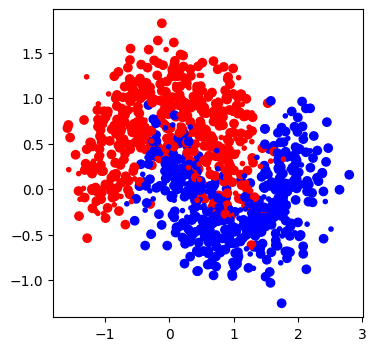

In [53]:
# Plot the training points
plt.figure(figsize=(4, 4))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
plt.scatter(X_test[:, 0], X_test[:, 1], marker='.', c=y_test, cmap=cm_bright)
plt.show()

### Subproblem 5.1. AdaBoost alphas and distributions (1 point)

Now let us define functions to calculate alphas and distributions for AdaBoost algorithm

In [54]:
def ada_boost_alpha(y, y_pred_t, distribution):
    """
    Function, which calculates the weights of the linear combination of the classifiers.

    y_pred_t is a prediction of the t-th base classifier
    """
    ### BEGIN Solution (do not delete this comment)
    error = np.sum(distribution * (y != y_pred_t))

    alpha = 0.5 * np.log((1 - error) / error)

    ### END Solution (do not delete this comment)

    return alpha

def ada_boost_distribution(y, y_pred_t, distribution, alpha_t):
    """
    Function, which calculates sample weights

    y_pred_t is a prediction of the t-th base classifier
    """
    ### BEGIN Solution (do not delete this comment)
    distribution = distribution * np.exp(-alpha_t * y * y_pred_t)
    
    C = np.sum(distribution)
    distribution /= C
    ### END Solution (do not delete this comment)

    return distribution

### Subproblem 5.2. Boosting implementation (1 point)

Implement your own AdaBoost algorithm. Then compare it with the `sklearn` implementation.

In [55]:
class Boosting():
    """
    Generic class for construction of boosting models

    :param n_estimators: int, number of estimators (number of boosting rounds)
    :param base_classifier: callable, a function that creates a weak estimator. Weak estimator should support sample_weight argument
    :param get_alpha: callable, a function, that calculates new alpha given current distribution, prediction of the t-th base estimator,
                      boosting prediction at step (t-1) and actual labels
    :param get_distribution: callable, a function, that calculates samples weights given current distribution, prediction, alphas and actual labels
    """
    def __init__(self, n_estimators=50, base_classifier=None,
                 get_alpha=ada_boost_alpha, update_distribution=ada_boost_distribution):
        self.n_estimators = n_estimators
        self.base_classifier = base_classifier
        self.get_alpha = get_alpha
        self.update_distribution = update_distribution

    def fit(self, X, y):
        n_samples = len(X)
        distribution = np.ones(n_samples, dtype=float) / n_samples
        self.classifiers = []
        self.alphas = []
        for i in range(self.n_estimators):
            # create a new classifier
            self.classifiers.append(self.base_classifier())
            self.classifiers[-1].fit(X, y, sample_weight=distribution)

            ### BEGIN Solution (do not delete this comment)

            y_pred_t = self.classifiers[-1].predict(X)
            alpha_t = self.get_alpha(y, y_pred_t, distribution)
            self.alphas.append(alpha_t)
            distribution = self.update_distribution(y, y_pred_t, distribution, alpha_t)
            ### END Solution (do not delete this comment)


    def predict(self, X):
        final_predictions = np.zeros(X.shape[0])

        ### BEGIN Solution (do not delete this comment)
        for clf, alpha in zip(self.classifiers, self.alphas):
            final_predictions += alpha * clf.predict(X)
        out = np.sign(final_predictions)

        ### END Solution (do not delete this comment)

        return out

In [56]:
from sklearn.ensemble import AdaBoostClassifier

max_depth = 5
n_estimators = 100

get_base_clf = lambda: DecisionTreeClassifier(max_depth=max_depth)
ada_boost = Boosting(n_estimators=n_estimators,
                     base_classifier=get_base_clf)
ada_boost.fit(X_train, y_train)

ada_boost_sklearn = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth),
                                       algorithm="SAMME",
                                       n_estimators=n_estimators)

ada_boost_sklearn.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=5),
                   n_estimators=100)

In [57]:
classifiers = [ada_boost, ada_boost_sklearn]
names = ['ada_boost', 'ada_boost_sklearn']

accuracy ada_boost: 0.895
accuracy ada_boost_sklearn: 0.89


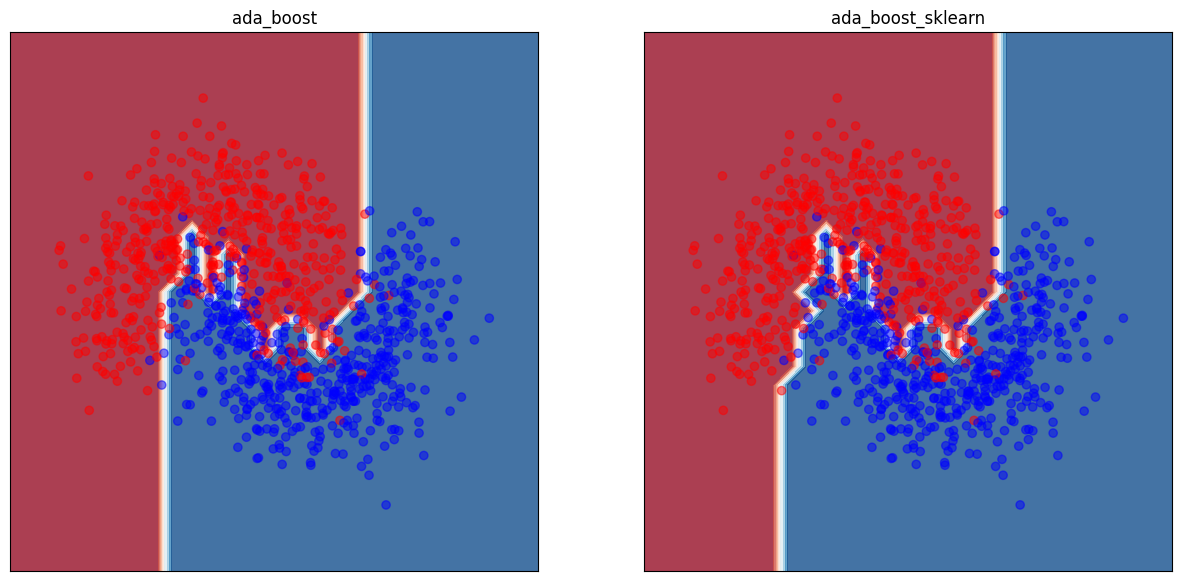

In [58]:
# # test ensemble classifier
plt.figure(figsize=(15, 7))
for i, clf in enumerate(classifiers):
    prediction = clf.predict(X_test)

    # Put the result into a color plot
    ax = plt.subplot(1, len(classifiers), i + 1)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

    # Plot also the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, alpha=0.5)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(names[i])

    print('accuracy {}: {}'.format(names[i], (prediction == y_test).sum() * 1. / len(y_test)))